# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Inference Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new data for final predictions.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for the weather measures and calendar. Then, we proceed to import some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar 

# We go back into the notebooks folder
%cd pipeline

c:\Users\Benjamin Ly\Documents\GitHub\bds_m7_second-semester-project


c:\Users\Benjamin Ly\anaconda3\envs\energy\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\Benjamin Ly\Documents\GitHub\bds_m7_second-semester-project\pipeline


c:\Users\Benjamin Ly\anaconda3\envs\energy\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Importing pandas for data handling
import pandas as pd
import numpy as np

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556180
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> ⚙️ Feature View Retrieval
We retrieve the Feature View and the training data from the Feature View `electricity_price_fw`.

In [4]:
# Retrieve the 'electricity_price_feature_view' feature view
electricity_price_fw = fs.get_feature_view(
    name='electricity_price_feature_view',
    version=1,
)

In [5]:
# Retrieve training data from the feature view 'electricity_price_fw', using the training_data() function from the feature_view_training module
df, _ = electricity_price_fw.training_data(
    description = 'Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (6.27s) 


### <span style='color:#2656a3'> 📮 Retrieving Model from Model Registry

In [6]:
# Importing joblib to load the model
import joblib

# Retrieve the model registry
mr = project.get_model_registry()

# Retrieving the model from the Model Registry
retrieved_model = mr.get_model(
    name="xgb_electricity_price_model", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Downloading the saved models to local directories
saved_model_dir = retrieved_model.download()

# Loading the saved XGBoost Regressor models
retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgb_electricity_price_model.pkl")

In [8]:
# Display the retrieved XGBoost Regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as new data to make predictions.

In [17]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.calendar_denmark(
    freq='H',
)

In [18]:
# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='timestamp', right_on='timestamp')

# Displaying the new data
new_data.tail()

,timestamp,datetime_x,date_x,hour_x,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,...,wind_speed_10m,wind_gusts_10m,datetime_y,date_y,hour_y,dayofweek,day,month,year,workday
115,1716922800000,2024-05-28 19:00:00,2024-05-28,19,12.8,87.0,0.0,0.0,0.0,0.0,...,3.9,11.2,2024-05-28 19:00:00,2024-05-28,19,1,28,5,2024,1
116,1716926400000,2024-05-28 20:00:00,2024-05-28,20,12.2,90.0,0.0,0.0,0.0,0.0,...,3.4,9.4,2024-05-28 20:00:00,2024-05-28,20,1,28,5,2024,1
117,1716930000000,2024-05-28 21:00:00,2024-05-28,21,11.7,92.0,0.0,0.0,0.0,0.0,...,3.8,7.2,2024-05-28 21:00:00,2024-05-28,21,1,28,5,2024,1
118,1716933600000,2024-05-28 22:00:00,2024-05-28,22,11.2,93.0,0.0,0.0,0.0,0.0,...,4.2,6.8,2024-05-28 22:00:00,2024-05-28,22,1,28,5,2024,1
119,1716937200000,2024-05-28 23:00:00,2024-05-28,23,10.9,92.0,0.0,0.0,0.0,0.0,...,3.5,6.8,2024-05-28 23:00:00,2024-05-28,23,1,28,5,2024,1


In [19]:
# Show information of the new data
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             120 non-null    int64         
 1   datetime_x            120 non-null    datetime64[ns]
 2   date_x                120 non-null    datetime64[ns]
 3   hour_x                120 non-null    int32         
 4   temperature_2m        120 non-null    float64       
 5   relative_humidity_2m  120 non-null    float64       
 6   precipitation         120 non-null    float64       
 7   rain                  120 non-null    float64       
 8   snowfall              120 non-null    float64       
 9   weather_code          120 non-null    float64       
 10  cloud_cover           120 non-null    float64       
 11  wind_speed_10m        120 non-null    float64       
 12  wind_gusts_10m        120 non-null    float64       
 13  datetime_y          

In [20]:
# Dropping and renaming columns
new_data.drop(columns=['datetime_y', 'hour_y', 'date_y'], inplace=True)
new_data.rename(columns={
    'date_x': 'date', 
    'datetime_x': 'datetime', 
    'hour_x': 'hour'}, inplace=True)

# Displaying the new data
new_data.tail()

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1716922800000,2024-05-28 19:00:00,2024-05-28,19,12.8,87.0,0.0,0.0,0.0,0.0,47.0,3.9,11.2,1,28,5,2024,1
116,1716926400000,2024-05-28 20:00:00,2024-05-28,20,12.2,90.0,0.0,0.0,0.0,0.0,23.0,3.4,9.4,1,28,5,2024,1
117,1716930000000,2024-05-28 21:00:00,2024-05-28,21,11.7,92.0,0.0,0.0,0.0,0.0,0.0,3.8,7.2,1,28,5,2024,1
118,1716933600000,2024-05-28 22:00:00,2024-05-28,22,11.2,93.0,0.0,0.0,0.0,0.0,1.0,4.2,6.8,1,28,5,2024,1
119,1716937200000,2024-05-28 23:00:00,2024-05-28,23,10.9,92.0,0.0,0.0,0.0,0.0,1.0,3.5,6.8,1,28,5,2024,1


In [21]:
# Show information of the new data after dropping and renaming columns
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             120 non-null    int64         
 1   datetime              120 non-null    datetime64[ns]
 2   date                  120 non-null    datetime64[ns]
 3   hour                  120 non-null    int32         
 4   temperature_2m        120 non-null    float64       
 5   relative_humidity_2m  120 non-null    float64       
 6   precipitation         120 non-null    float64       
 7   rain                  120 non-null    float64       
 8   snowfall              120 non-null    float64       
 9   weather_code          120 non-null    float64       
 10  cloud_cover           120 non-null    float64       
 11  wind_speed_10m        120 non-null    float64       
 12  wind_gusts_10m        120 non-null    float64       
 13  dayofweek           

To make predictions based on the new date, we must match it to the schema of the training data. We start by sorting the training data retrieved from the feature store based on the timestamp and then use the append method in Pandas to concatenate the two DataFrames. After combining the dataframes we can add columns of moving windows to the combined data to match the schema of the training data.

In [22]:
# Sort the retrived training data from the feature view based on the values in the 'timestamp' column in ascending order
df.sort_values(by='timestamp', ascending=True, inplace=True)

# Reset the index of the DataFrame 'df'
df = df.reset_index(drop=True)

# Display the last few rows of the DataFrame 'df' after sorting and resetting the index
df.tail()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
38499,1716537600000,2024-05-24 08:00:00+00:00,2024-05-24 00:00:00+00:00,8,0.86487,0.411862,0.316903,0.390037,0.429451,0.413465,...,0.0,3.0,100.0,10.8,22.3,4,24,5,2024,1
38500,1716541200000,2024-05-24 09:00:00+00:00,2024-05-24 00:00:00+00:00,9,0.79174,0.413256,0.316333,0.389713,0.429391,0.413701,...,0.0,3.0,100.0,11.9,24.5,4,24,5,2024,1
38501,1716544800000,2024-05-24 10:00:00+00:00,2024-05-24 00:00:00+00:00,10,0.71756,0.414963,0.316828,0.389424,0.429501,0.413917,...,0.0,3.0,95.0,13.3,26.6,4,24,5,2024,1
38502,1716548400000,2024-05-24 11:00:00+00:00,2024-05-24 00:00:00+00:00,11,0.67212,0.416732,0.317739,0.389190,0.429791,0.414122,...,0.0,3.0,96.0,12.2,26.6,4,24,5,2024,1
38503,1716552000000,2024-05-24 12:00:00+00:00,2024-05-24 00:00:00+00:00,12,0.62100,0.418720,0.318710,0.388984,0.430223,0.414361,...,0.0,3.0,97.0,11.2,25.2,4,24,5,2024,1


In [26]:
combined_data = pd.concat([df, new_data], ignore_index=True)


In [27]:
# Display the last few rows of the combined data
combined_data.tail()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
38619,1716922800000,2024-05-28 19:00:00,2024-05-28 00:00:00,19,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,47.0,3.9,11.2,1,28,5,2024,1
38620,1716926400000,2024-05-28 20:00:00,2024-05-28 00:00:00,20,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,23.0,3.4,9.4,1,28,5,2024,1
38621,1716930000000,2024-05-28 21:00:00,2024-05-28 00:00:00,21,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,3.8,7.2,1,28,5,2024,1
38622,1716933600000,2024-05-28 22:00:00,2024-05-28 00:00:00,22,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,4.2,6.8,1,28,5,2024,1
38623,1716937200000,2024-05-28 23:00:00,2024-05-28 00:00:00,23,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,3.5,6.8,1,28,5,2024,1


In [28]:
# Defining a copy of the combined data to avoid modifying the original dataframe
rolled_data = combined_data.copy()

# Adding a column with the mean for the previous 1 week
rolled_data['prev_1w_mean'] = rolled_data['dk1_spotpricedkk_kwh'].rolling(window=24*7, min_periods=1).mean()

# Adding a column with the mean for the previous 2 weeks
rolled_data['prev_2w_mean'] = rolled_data['dk1_spotpricedkk_kwh'].rolling(window=24*14, min_periods=1).mean()

# Adding a column with the mean for the previous 4 weeks
rolled_data['prev_4w_mean'] = rolled_data['dk1_spotpricedkk_kwh'].rolling(window=24*28, min_periods=1).mean()

# Displaying the last 120 rows of the DataFrame
rolled_data.tail(120)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
38504,1716508800000,2024-05-24 00:00:00,2024-05-24 00:00:00,0,NaN,0.370662,0.321691,0.394992,NaN,NaN,...,0.0,3.0,100.0,11.5,21.2,4,24,5,2024,1
38505,1716512400000,2024-05-24 01:00:00,2024-05-24 00:00:00,1,NaN,0.372902,0.322681,0.394842,NaN,NaN,...,0.0,3.0,100.0,12.6,22.3,4,24,5,2024,1
38506,1716516000000,2024-05-24 02:00:00,2024-05-24 00:00:00,2,NaN,0.375161,0.323665,0.394660,NaN,NaN,...,0.0,3.0,100.0,13.3,23.8,4,24,5,2024,1
38507,1716519600000,2024-05-24 03:00:00,2024-05-24 00:00:00,3,NaN,0.376994,0.324625,0.394438,NaN,NaN,...,0.0,3.0,87.0,9.0,20.9,4,24,5,2024,1
38508,1716523200000,2024-05-24 04:00:00,2024-05-24 00:00:00,4,NaN,0.378516,0.324152,0.394136,NaN,NaN,...,0.0,2.0,74.0,11.9,20.9,4,24,5,2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38619,1716922800000,2024-05-28 19:00:00,2024-05-28 00:00:00,19,NaN,0.442488,0.317544,0.373161,NaN,NaN,...,0.0,0.0,47.0,3.9,11.2,1,28,5,2024,1
38620,1716926400000,2024-05-28 20:00:00,2024-05-28 00:00:00,20,NaN,0.444290,0.318801,0.372799,NaN,NaN,...,0.0,0.0,23.0,3.4,9.4,1,28,5,2024,1
38621,1716930000000,2024-05-28 21:00:00,2024-05-28 00:00:00,21,NaN,0.448420,0.320343,0.372636,NaN,NaN,...,0.0,0.0,0.0,3.8,7.2,1,28,5,2024,1
38622,1716933600000,2024-05-28 22:00:00,2024-05-28 00:00:00,22,NaN,0.452788,0.321934,0.372675,NaN,NaN,...,0.0,0.0,1.0,4.2,6.8,1,28,5,2024,1


In [29]:
# Select the last 120 rows of the DataFrame 'rolled_data' and store them in 'forecast_data'
forecast_data = rolled_data.tail(120)

In [30]:
# Display the first few rows of the DataFrame 'forecast_data'
forecast_data.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
38504,1716508800000,2024-05-24 00:00:00,2024-05-24 00:00:00,0,NaN,0.370662,0.321691,0.394992,NaN,NaN,...,0.0,3.0,100.0,11.5,21.2,4,24,5,2024,1
38505,1716512400000,2024-05-24 01:00:00,2024-05-24 00:00:00,1,NaN,0.372902,0.322681,0.394842,NaN,NaN,...,0.0,3.0,100.0,12.6,22.3,4,24,5,2024,1
38506,1716516000000,2024-05-24 02:00:00,2024-05-24 00:00:00,2,NaN,0.375161,0.323665,0.394660,NaN,NaN,...,0.0,3.0,100.0,13.3,23.8,4,24,5,2024,1
38507,1716519600000,2024-05-24 03:00:00,2024-05-24 00:00:00,3,NaN,0.376994,0.324625,0.394438,NaN,NaN,...,0.0,3.0,87.0,9.0,20.9,4,24,5,2024,1
38508,1716523200000,2024-05-24 04:00:00,2024-05-24 00:00:00,4,NaN,0.378516,0.324152,0.394136,NaN,NaN,...,0.0,2.0,74.0,11.9,20.9,4,24,5,2024,1


In [31]:
# Drop columns 'dk1_spotpricedkk_kwh', 'timestamp', 'datetime', and 'date' from the DataFrame 'forecast_data'
forecast_data.drop(columns=['dk1_spotpricedkk_kwh','timestamp', 'datetime', 'date'], inplace=True)

In [32]:
# Display the first few rows of the DataFrame 'forecast_data'
forecast_data.head()

,hour,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,temperature_2m,relative_humidity_2m,precipitation,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
38504,0,0.370662,0.321691,0.394992,NaN,NaN,NaN,14.4,94.0,0.0,...,0.0,3.0,100.0,11.5,21.2,4,24,5,2024,1
38505,1,0.372902,0.322681,0.394842,NaN,NaN,NaN,14.4,92.0,0.0,...,0.0,3.0,100.0,12.6,22.3,4,24,5,2024,1
38506,2,0.375161,0.323665,0.394660,NaN,NaN,NaN,14.1,89.0,0.0,...,0.0,3.0,100.0,13.3,23.8,4,24,5,2024,1
38507,3,0.376994,0.324625,0.394438,NaN,NaN,NaN,13.9,90.0,0.0,...,0.0,3.0,87.0,9.0,20.9,4,24,5,2024,1
38508,4,0.378516,0.324152,0.394136,NaN,NaN,NaN,13.9,93.0,0.0,...,0.0,2.0,74.0,11.9,20.9,4,24,5,2024,1


## <span style="color:#2656a3;">🤖 Making the predictions</span>

We now want to make predictions based on our trained model from Hopsworks and the forecasted weather measures.

In [33]:
# Make predictions using the retrieved XGBoost model on the 'forecast_data'
# The 'predict' method is called on the 'retrieved_xgboost_model' object, passing 'forecast_data' as input
predictions = retrieved_xgboost_model.predict(forecast_data)

# Print predictions
print(predictions)

[ 1.3417634   1.207286    1.09347     1.0067647   1.0847939   1.2751926
  1.2335774   1.5605913   1.4927856   1.2551266   0.19884586  0.2257026
  0.00884472 -0.14508964 -0.08456384  0.04657561  0.03912616  0.1368075
  0.14062937  0.25772712  0.15856913  0.5835685   0.6048332   0.53523076
  1.2756171   1.1245544   1.159753    1.1964023   1.1964023   1.160531
  0.9128739   0.44895935  0.6581485   0.25396898  0.10894246  0.18280904
  0.17238162 -0.11446826 -0.15224937 -0.18098181 -0.14912719  0.06142384
  0.25898972  0.36860964  0.73230314  0.7423456   0.46476024  0.33930925
  1.0341868   0.8351074   0.8391512   0.8266176   1.043746    0.8415162
  0.88594157  0.96315944  1.3449785   0.9880874   1.13379     0.96607065
  0.6613096  -0.03266669 -0.10005757 -0.04088497  0.01926369  0.18671745
  0.3530215   0.9817883   0.86645824  0.67087924  0.4589544   0.5141082
  0.63054144  0.5190979   0.60217977  0.5527177   0.44969106  0.805261
  0.86293423  1.0781517   1.1988358   0.91968435  0.17520188

In [34]:
# Make a dictionary of the predictions and the corresponding time for the forecast weather measures
predictions_data = {
    'prediction': predictions,
    'time': new_data["datetime"],
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the new electricity price predictions
predictions_df

,prediction,time
0,1.341763,2024-05-24 00:00:00
1,1.207286,2024-05-24 01:00:00
2,1.093470,2024-05-24 02:00:00
3,1.006765,2024-05-24 03:00:00
4,1.084794,2024-05-24 04:00:00
...,...,...
115,0.821708,2024-05-28 19:00:00
116,0.771327,2024-05-28 20:00:00
117,0.768415,2024-05-28 21:00:00
118,0.736619,2024-05-28 22:00:00


### <span style="color:#2656a3;">📊 Plot the predictions</span>

Now we plot the predictions as a linechart for the comming five days.
We are plotting the linechart with both matplotlib and Altair for interactive visualization.

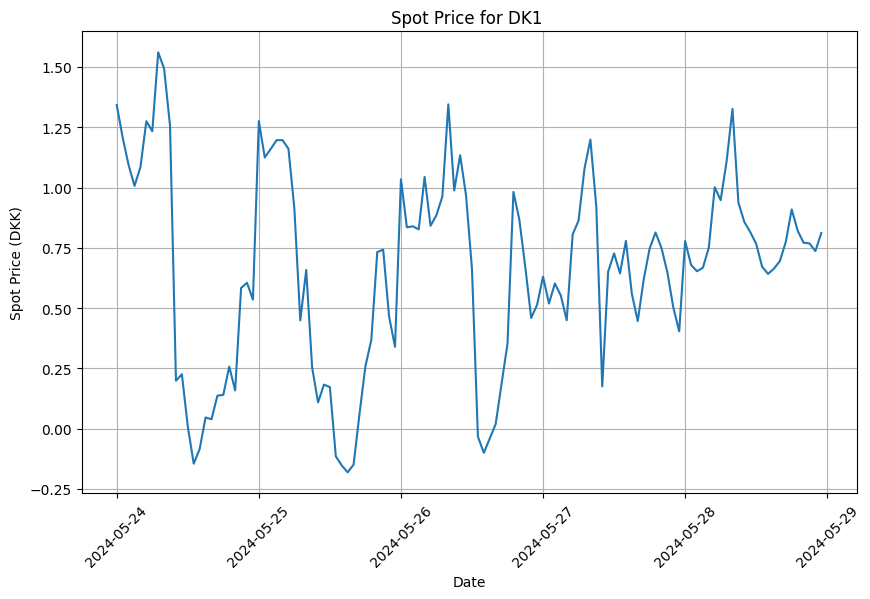

In [35]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Group the data by date and calculate the average temperature for each day
daily_data = predictions_df.groupby('time')['prediction'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK)')
plt.title('Spot Price for DK1 ')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [36]:
# Importing Altair for interactive visualization
import altair as alt

# Create Altair chart with line and dots
chart = alt.Chart(predictions_df).mark_line(point=True).encode(
    x='time:T', 
    y='prediction:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('time:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('time:T', title='Time', format='%H:%M'), 
             alt.Tooltip('prediction:Q', title='Spot Price (DKK)', format='.2f'),
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#2656a3;">⏭️ **Next:** Creating our Python files for a Streamlit application ([link to Github repository](https://github.com/tobiasmj97/bds_m7_second-semester-project_streamlit)) </span>
